# Recommendation Systems - MITXPro

This is my solution for Case Study 4.1 of MITXPro Data Science and Big Data Analytics. This is a simple recomendation system using some of the MovieLens (http://grouplens.org/datasets/movielens) dataset. Specifically, the 100K dataset.

Basically, I use population averages as a base case and then Alternating Least Squares (ALS) to implement a collaborative filter.

There are some libraries that implement many recommendaton algorithms (such as RecommenderLab and Graphlab-Create), but I decided to implement myself population and ALS algorithms. So, all I import is the following:

In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split

In [2]:
col_names = ["user_id", "item_id", "rating", "timestamp"]
data = pd.read_table("u.data", names=col_names)
data = data.drop("timestamp", 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
user_id    100000 non-null int64
item_id    100000 non-null int64
rating     100000 non-null int64
dtypes: int64(3)
memory usage: 2.3 MB


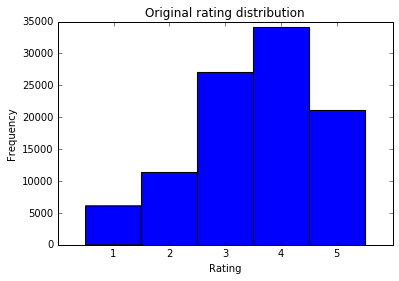

In [3]:
def hist(data, title=None):
    """Plot a histogram of ratings. This assumes ratings goes from 1 to 5.
    
    Args:
        data (pandas DataFrame): Dataframe with a "rating" column.
        
        title (str): title of the graph
    """
    plt.hist(data["rating"],bins=np.arange(1,7) - 0.5, edgecolor='black', linewidth=1.1)
    plt.xticks(np.arange(1,6))
    if title != None:
        plt.title(title)
    plt.xlabel("Rating")
    plt.ylabel("Frequency")
    plt.show()
    
hist(data, "Original rating distribution")

Checking the sparcity of the data:

In [4]:
Number_Ratings = len(data)
Number_Movies = len(np.unique(data["item_id"]))
Number_Users = len(np.unique(data["user_id"]))

print "Sparcity of the original dataframe: %.2f%%" % ( float(Number_Ratings)/(Number_Movies*Number_Users)*100)

Sparcity of the original dataframe: 6.30%


The next function will subset the data to make it less sparse. The user specify a threshold in the number of observations and the data is subsetted accordingly.

In [5]:
def subSettingData(data, userThold, movieThold):
    """Select Users/Movies that have at least userThold/movieThold observations.
    
    Select Users that have at least userThold observation, and, after thresholding
    users, select Movies that have at least movieThold observations.

    Args:
        data (pandas DataFrame): Dataframe with columns "user_id", "item_id",
            "rating".
        userThold (int): user observation threshold
        movieThold (int): movie observation threshold
        
    Returns:
        pandas DataFrame: subsetted Dataframe
    """
    # thesholding users first
    c={x: 0 for x in set(data['user_id'].values)}
    for i in data['user_id'].values:
        c[i]+=1
    keepUsers=set(filter(lambda x: c[x] > userThold, c))
    res=data[data['user_id'].isin(keepUsers)]
    # then thesholding movies
    c={x:0 for x in set(res['item_id'].values)}
    for i in res['item_id'].values:
        c[i]+=1
    keepMovies=set(filter(lambda x: c[x] > movieThold, c))
    res=res[res['item_id'].isin(keepMovies)]
    return res

I will use a theshold of 50 in both user and movie observations:

In [6]:
data2 = subSettingData(data, 50, 50)

The sparcity was sensibly reduced:

In [7]:
Number_Ratings2 = len(data2)
Number_Movies2 = len(np.unique(data2["item_id"]))
Number_Users2 = len(np.unique(data2["user_id"]))

print "Sparcity of the original dataframe: %.2f%%" % ( float(Number_Ratings2)/(Number_Movies2*Number_Users2)*100)

Sparcity of the original dataframe: 22.51%


And the historgram:

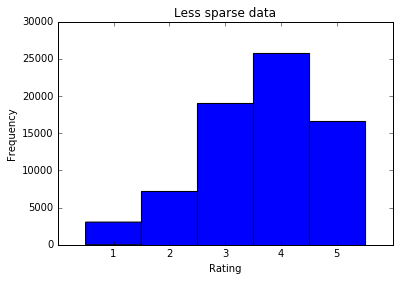

In [8]:
hist(data2, "Less sparse data")

Here I create some dictionaries to map the user_id and item_id to matrices indices in the appropriate matrix

In [9]:
def getMaps(data):
    """return maps to/from user_id/item_id from/to matrix index
    
    This should be used with the full dataframe, i.e. before splitting
    the dataframe into train, validation and test sets
    
    Args:
        data(pandas Dataframe): dataframe with columns "item_id"
            and "user_id"
            
    Returns:
        tuple of four dictionaries, first maps users to matrix row
        second maps movies to matrix columns, third maps row matrix
        to user (inverse map of fist map) and fourth maps matrix
        column to movies
    """
    col2Movie={i:j for i,j in enumerate(np.unique(data["item_id"]))}
    movie2Col={col2Movie[i] : i for i in col2Movie}
    row2User={i:j for i,j in enumerate(np.unique(data["user_id"]))}
    user2Row={row2User[i] : i for i in row2User}
    return user2Row, movie2Col, row2User, col2Movie

In [10]:
user2Row, movie2Col, row2User, col2Movie = getMaps(data2)

Below, the less sparse dataframe is splited into train+validation (70% of the total) and test (30%) sets. Furthermore, the first set is splitted again into train (75%) and validation (25%).

In [11]:
trainValid2, test2 = train_test_split(data2, test_size = 0.3)
train2, valid2 = train_test_split(trainValid2, test_size = 0.25)

Rather than using a library I decided implementing myself the population and a collaborative algorithms. Particularly, I implemented Alternating Least Squares (ALS) that is quite simple and intuitive.

The next function implements the population tranning, where I use the trainning set to compute averages across movies and use those averages to fill in the remainder of the matrix.

In [12]:
def pop_train(nusers, nmovies, data):
    """this function train using the population averages. 
    
    Args:
        nusers (int): total number of users in the full set, i.e.
            train+validation+test set
        nmovies (int): total number of movies in the full set
        data (pandas Dataframe): dataframe with the trainning set
    
    Returns:
        numpy.array : recommendation matrix completely filled.
    """
    R=np.zeros((nusers, nmovies))
    W=np.zeros_like(R)
    for i,j,l in data.values:
        R[user2Row[i], movie2Col[j]] = l
        W[user2Row[i], movie2Col[j]] = 1 if l > 0 else 0
    y=np.sum(R, axis=0)/np.sum(W, axis=0)
    y=np.tile(y, (R.shape[0],1))
    R[W==0]=y[W==0]
    return R

In [13]:
def pop_predict(R, l):
    """using the matrix returned by pop_train predicts ratings of a list of pairs user
       and movie.
       
    Args:
        R (np.array): ratings matrix trained with pop_train
        
    Returns:
        numpy.array: predicted labels yhat
    """
    res=[]
    for u, m in l:
        res.append( R[user2Row[u], movie2Col[m]] )
    return np.array(res)

In [14]:
def rmse(y,yhat):
    """compute rmse between two vectors
    
    Args:
        y (np.array): true labels
        yhat (np.array): prediction
    
    Returns:
        float: rmse
    """
    return np.sqrt( np.mean(np.power(y-yhat,2.0)) )

Evaluating the population algorithm with the test set:

In [15]:
# Since there is no need to fine tune the population algorithm I am using
#   the train + validation sets to train it
R2=pop_train(Number_Users2, Number_Movies2, trainValid2)
yhat2=pop_predict(R2, test2.values[:,0:2])
rmse(test2.values[:,2], yhat2)

0.9883287659112111

## Alternating Least Squares

An intuitive description of Alternating Least Squares (ALS) is as follows:

We want to compute a low rank (rank k) fatorization of the true (and complete) rating matrix $R$ (dimensions n by m, where n is the number of users, and m is the number of movies) as follows:

$\;\;\;X^T\cdot Y=R$

where $X$ is the user feature matrix (dimensions k by n) and $Y$ is the movie feature matrix (dimensions k by m).

We can formulate this as an optimization problem of this form:

$\;\;\;min (X^T\cdot Y - R)^2$

But this is not convex, since we want to find both $X$ and $Y$. But if we knew $Y$, we could apply least squares to find X, and, in the other hand, if we knew $X$ we could apply least squares to find $Y$. This is basically what ALS does: it pretends to know one variable (at the beginning initializing it randomily) and solves for the other variable. Next step, the variables invert roles and a new least squares is used.

Before presenting the formulation, we need to realize that what we have is not $R$ but an incomplete matrix. If you think of a particular user $u$, what we have is:

$\;\;\;W_u \cdot Y^T \cdot x_u=W_u \cdot r_u^T$

where $x_u$ is the column of $X$ corresponding to user $u$, $r_u$ is the row of $R$ also corresponding to $u$ and $W_u$ is a diagonal matrix with ones only in the possitions where we actually have observations of $u$. In the same way, for movies we have:

$\;\;\;W_m \cdot X^T\cdot y_m=W_m \cdot r_m$

where $y_m$ is the column of $Y$ corresponding to movie $m$, $r_m$ is the column of $R$ also corresponding to $m$ and $W_m$ is a diagonal matrix with ones only in the possitions where we actually have observations of $m$.

We can then write the normal equations as follows (noting that $W_u^T \cdot W_u = W_u$ and $W_m^T \cdot W_m = W_m$, since they are just diagonals of only ones and zeros):

$\;\;\;Y \cdot W_u \cdot Y^T \cdot x_u=Y \cdot W_u \cdot r_u^T$

and

$\;\;\;X \cdot W_m \cdot X^T \cdot y_m=X \cdot W_m \cdot r_m$

Adding regularization and solving (alternatingly) for $x_u$ and $y_m$:

$\;\;\;x_u= (Y \cdot W_u \cdot Y^T + \lambda \cdot I)^{-1} \cdot Y \cdot W_u \cdot r_u^T$

$\;\;\;y_m= (X \cdot W_m \cdot X^T + \lambda \cdot I)^{-1} \cdot X \cdot W_m \cdot r_m$

where $\lambda$ is the regularization parameter and $I$ is the identity matrix of appropriate size (k by k).

A more formal description of this algorithm can be found here:

Hu, Yifan, Yehuda Koren, and Chris Volinsky. "Collaborative filtering for implicit feedback datasets." *Data Mining, 2008. ICDM'08. Eighth IEEE International Conference on*. Ieee, 2008.

The code below implements this algorithm:

In [16]:
def als_train(nusers, nmovies, data, k=20, lmbda=1.0):
    TOL=1e-16
    R=np.zeros((nusers, nmovies))
    W=np.zeros((nusers, nmovies))
    for i,j,l in data.values:
        R[user2Row[i], movie2Col[j]] = l
        W[user2Row[i], movie2Col[j]] = 1 if l > 0 else 0
    Y=np.random.random((k, nmovies))
    Yaux=np.zeros_like(Y)
    X=np.zeros((k, nusers))
    while(True):
        for u in range(nusers):
            X[:,u] = np.linalg.inv(Y.dot(np.diag(W[u,:])).dot(Y.T) + lmbda*np.eye(k)).\
                     dot(Y.dot(np.diag(W[u,:])).dot(R[u,:]))
        for m in range(nmovies):
            Yaux[:,m] = np.linalg.inv(X.dot(np.diag(W[:,m])).dot(X.T) + lmbda*np.eye(k)).\
                        dot(X.dot(np.diag(W[:,m])).dot(R[:,m]))
        #print np.sqrt(np.mean(np.power(Y-Yaux,2)))
        if np.sqrt(np.mean(np.power(Y-Yaux,2))) < TOL:
            break
        else:
            Y=Yaux
    return X, Y

In [17]:
def als_predict(X, Y, l):
    res=[]
    for u, m in l:
        res.append( np.dot(X.T[user2Row[u],:], Y[:,movie2Col[m]]) )
    return np.array(res)

In addition to regularization ($\lambda$), we need also to set the number of features $k$. So, in the following cells, I look for both the best regularization level and number of features.

In [18]:
ks=[2,3,4]
lmbdas=[0.1, 1.0, 2.0, 10.0]

In [19]:
res={}
for k in ks:
    for l in lmbdas:
        X,Y=als_train(Number_Users2, Number_Movies2, train2, k=k, lmbda=l)
        yhat=als_predict(X,Y,valid2.values[:,0:2])
        y=valid2.values[:,2]
        res[(k,l)] = rmse(y,yhat)
        print "(%d, %f) -> %f" % (k,l,res[(k,l)])

(2, 0.100000) -> 0.930904
(2, 1.000000) -> 0.918056
(2, 2.000000) -> 0.921690
(2, 10.000000) -> 0.957205
(3, 0.100000) -> 0.967826
(3, 1.000000) -> 0.942400
(3, 2.000000) -> 0.940645
(3, 10.000000) -> 0.951883
(4, 0.100000) -> 0.972675
(4, 1.000000) -> 0.958668
(4, 2.000000) -> 0.930234
(4, 10.000000) -> 0.933366


In [20]:
X,Y=als_train(Number_Users2, Number_Movies2, train2, k=2, lmbda=1)
yhat=als_predict(X,Y, test2.values[:,0:2])
print rmse(test2.values[:,2], yhat)

0.941725160099


## Top-K

In [41]:
def pop_recommend(R, k):
    res={}
    for i in range(R.shape[0]): # for each row (user)
        u=row2User[i]
        l = []
        for j in range(R.shape[1]): # for each column (movie)
            m=col2Movie[j]
            r=R[i,j]
            l.append((m,r))
        res[u] = sorted(l, key=lambda x: -x[1])[0:k]
    return res

In [42]:
def als_recommend(X, Y, k):
    Rhat=np.dot(X.T,Y)
    res={}
    for i in range(Rhat.shape[0]): # for each row (user)
        u=row2User[i]
        l = []
        for j in range(Rhat.shape[1]): # for each column (movie)
            m=col2Movie[j]
            r=Rhat[i,j]
            l.append((m,r))
        res[u] = sorted(l, key=lambda x: -x[1])[0:k]
    return res

In [43]:
topr_als=als_recommend(X,Y,20)
topr_pop=pop_recommend(R2, 20)

In [44]:
def get_topk(data, k):
    res={x : [] for x in np.unique(data['user_id'].values)}
    for i in range(data.values.shape[0]):
        res[data.values[i,0]].append((data.values[i,1], data.values[i,2]))
    for i in res:
        res[i] = sorted(res[i], key=lambda x: -x[1])[0:k]
    return res

In [45]:
topk=get_topk(test2, 10)

In [46]:
def get_confusion_matrix(topk, topr, data):
    allMovies = np.unique(data['item_id'].values)
    allUsers = np.unique(data['user_id'].values)
    conf_mat = np.zeros((2,2))
    for u in allUsers:
        positives = np.array(map(lambda x: x[0], topk[u]))
        negatives = np.setdiff1d(allMovies, positives)
        predictPositive = np.array(map(lambda x: x[0], topr[u]))
        predictNegative = np.setdiff1d(allMovies, predictPositive)
        truePositives = len(np.intersect1d(positives, predictPositive))
        trueNegatives = len(np.intersect1d(negatives, predictNegative))
        falsePositives = len(np.intersect1d(negatives, predictPositive))
        falseNegatives = len(np.intersect1d(positives, predictNegative))
        conf_mat[0,0] += truePositives
        conf_mat[1,1] += trueNegatives
        conf_mat[0,1] += falsePositives
        conf_mat[1,0] += falseNegatives
    return conf_mat

In [47]:
conf_mat=get_confusion_matrix(topk, topr_pop, test2)

In [48]:
print "Precision: %f" % (conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1]))
print "Recall: %f" % (conf_mat[0,0]/(conf_mat[0,0]+conf_mat[1,0]))

Precision: 0.018117
Recall: 0.036318


In [49]:
conf_mat=get_confusion_matrix(topk, topr_als, test2)

In [52]:
print "Precision: %f" % (conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1]))
print "Recall: %f" % (conf_mat[0,0]/(conf_mat[0,0]+conf_mat[1,0]))

Precision: 0.047513
Recall: 0.095247
